In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cProfile
import pstats
import pandas as pd
from datetime import datetime
import os
import ast

# Tuning Resnet Based NN

## Common code for different explorations

In [2]:
def get_csvs_ending_with(title,folder_search="../../results/ResNetTuning/Results/"):
    file_path_list=[];
    for dirpath, dnames, fnames in os.walk(folder_search):
        for f in fnames:
            if f.endswith("_"+title+".csv"):
                file_path_list.append(folder_search+f);
    return file_path_list;
def get_param(filepath,param,log_folder="../../results/ResNetTuning/Logs/"):
    retVal=None
    name_log=os.path.basename(filepath)[:-3]+"txt"; #Changes extension.
    with open(log_folder+name_log, 'r') as fp:
        line = fp.readline()
        while line != "": #File not finished
            if line.find(param)!= -1: #Text found
                retVal=float(line[len(param)+2:]) #Removes ": " between param and value.
                break;
            line = fp.readline()
    return retVal;

## LR tuning

In [3]:
def get_values_plot(df):
    n=len(df);
    keys=["Train Losses","Train Aug Losses","Valid Losses"];
    means=[];stds=[];
    for key in keys:
        list_of_numpy_arrays=[]; lengths=np.zeros((n,),dtype=int);
        for i in range(n): #For each row
            string_results=df[key][i]; ##String that has the whole array of losses
            list_of_numpy_arrays.append(np.asarray(ast.literal_eval(string_results.replace(" ", ","))))
            lengths[i]=len(list_of_numpy_arrays[-1]);
        len_out=np.max(lengths)
        aux_means=[];aux_stds=[];
        for i in range(len_out):
            run_idxs_to_consider=np.argwhere(i<lengths)[:,0]
            aux_vect=[];
            for run_idx in run_idxs_to_consider:
                aux_vect.append(list_of_numpy_arrays[run_idx][i]);
            aux_means.append(np.mean(aux_vect))
            aux_stds.append(np.std(aux_vect));
        means.append(np.asarray(aux_means));
        stds.append(np.asarray(aux_stds));
    l_train_mean=means[0];l_train_stds=stds[0];
    l_train_aug_mean=means[1];l_train_aug_stds=stds[1];
    l_valid_mean=means[2];l_valid_stds=stds[2];
    return l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds
def print_accuracies_df(df):
    all_accs=df.iloc[:,:3].values;
    all_means=np.mean(all_accs,axis=0)
    all_stds=np.std(all_accs,axis=0)
    print("Train Acc: " + "{:.2f}".format(all_means[0]*100) + " +- " + "{:.2f}".format(all_stds[0]*100) + " % ")
    print("Valid Acc: " + "{:.2f}".format(all_means[1]*100) + " +- " + "{:.2f}".format(all_stds[1]*100) + " % ")
    print("Test Acc: " + "{:.2f}".format(all_means[2]*100) + " +- " + "{:.2f}".format(all_stds[2]*100) + " % ")
    n_samples=np.shape(all_accs)[0];
    median_test=np.median(all_accs[:,-1]);
    print("Test Accuracy estimator: " + "{:.2f}".format(all_means[2]*100) + " +- " + "{:.2f}".format(all_stds[2]*100/np.sqrt(n_samples)) + " % . Median:" + "{:.2f}".format(median_test*100))

Learning rate: 5e-05
Train Acc: 96.81 +- 0.37 % 
Valid Acc: 95.75 +- 0.29 % 
Test Acc: 91.76 +- 1.86 % 
Test Accuracy estimator: 91.76 +- 0.42 % . Median:91.70
Learning rate: 0.0001
Train Acc: 96.93 +- 0.36 % 
Valid Acc: 95.79 +- 0.27 % 
Test Acc: 92.04 +- 2.13 % 
Test Accuracy estimator: 92.04 +- 0.48 % . Median:92.62
Learning rate: 0.0005
Train Acc: 96.56 +- 0.59 % 
Valid Acc: 95.68 +- 0.39 % 
Test Acc: 92.28 +- 2.25 % 
Test Accuracy estimator: 92.28 +- 0.50 % . Median:92.70
Learning rate: 0.001
Train Acc: 96.32 +- 0.54 % 
Valid Acc: 95.45 +- 0.52 % 
Test Acc: 91.33 +- 1.85 % 
Test Accuracy estimator: 91.33 +- 0.41 % . Median:91.33


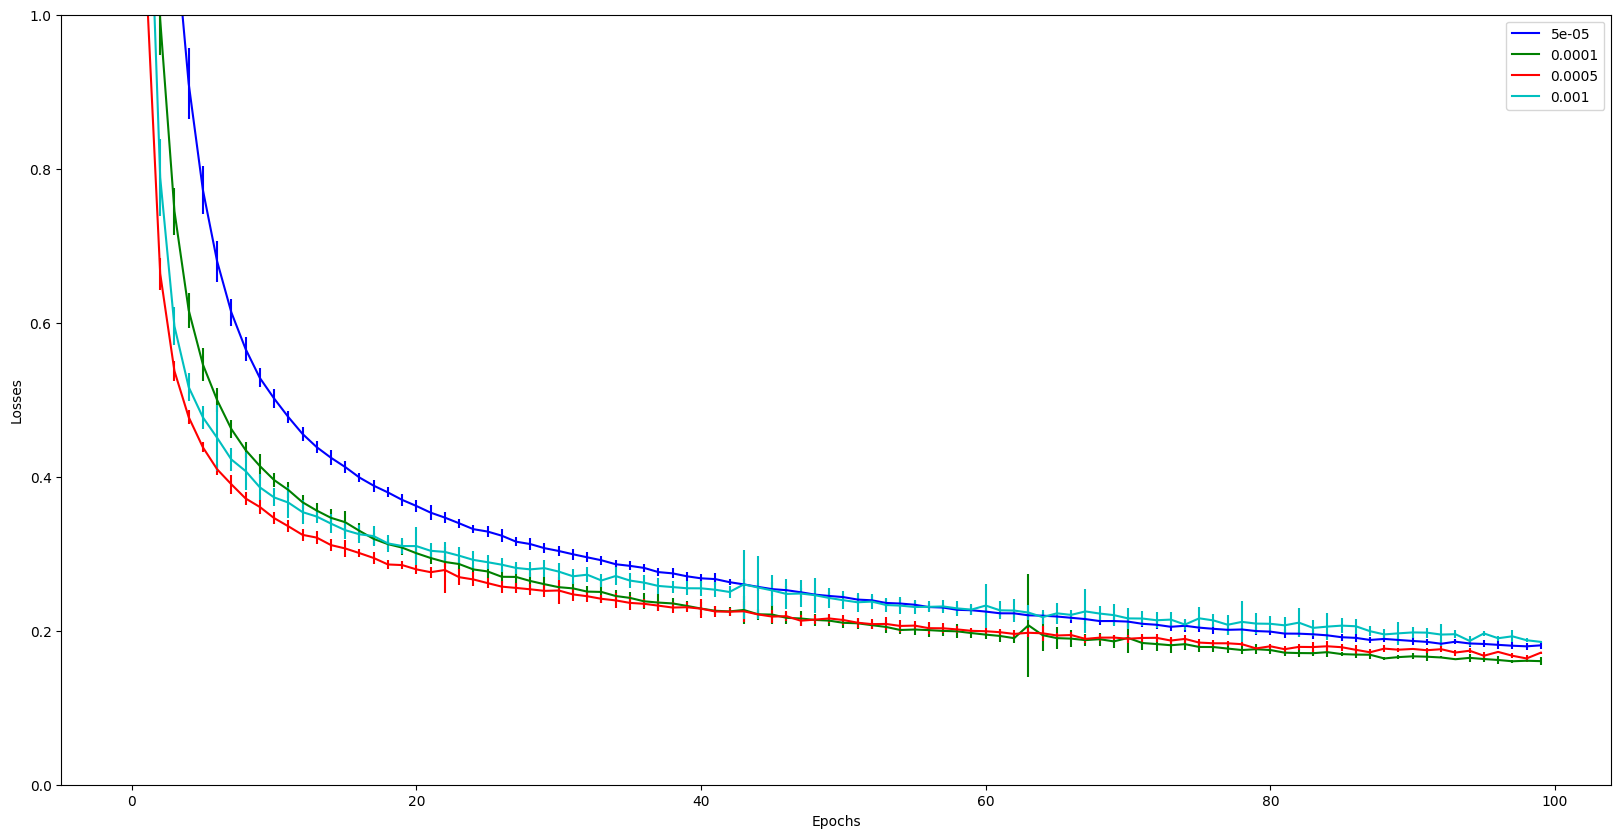

In [150]:
csvs_paths=get_csvs_ending_with("LR")
lrs=[get_param(i,"lr") for i in csvs_paths]
n_experiments=len(lrs)
idxs_sorted=np.argsort(lrs)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
lrs=np.sort(lrs)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("Learning rate: " + str(lrs[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    #plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(lrs[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

## Search for minibatch

batch size: 32.0
Train Acc: 97.18 +- 0.38 % 
Valid Acc: 96.06 +- 0.34 % 
Test Acc: 90.30 +- 2.76 % 
Test Accuracy estimator: 90.30 +- 0.87 % . Median:90.82
batch size: 64.0
Train Acc: 97.33 +- 0.43 % 
Valid Acc: 96.02 +- 0.32 % 
Test Acc: 92.41 +- 1.62 % 
Test Accuracy estimator: 92.41 +- 0.51 % . Median:92.58
batch size: 128.0
Train Acc: 96.89 +- 0.47 % 
Valid Acc: 95.83 +- 0.28 % 
Test Acc: 91.45 +- 1.50 % 
Test Accuracy estimator: 91.45 +- 0.47 % . Median:91.60
batch size: 256.0
Train Acc: 97.16 +- 0.62 % 
Valid Acc: 95.83 +- 0.46 % 
Test Acc: 93.74 +- 1.22 % 
Test Accuracy estimator: 93.74 +- 0.39 % . Median:93.19


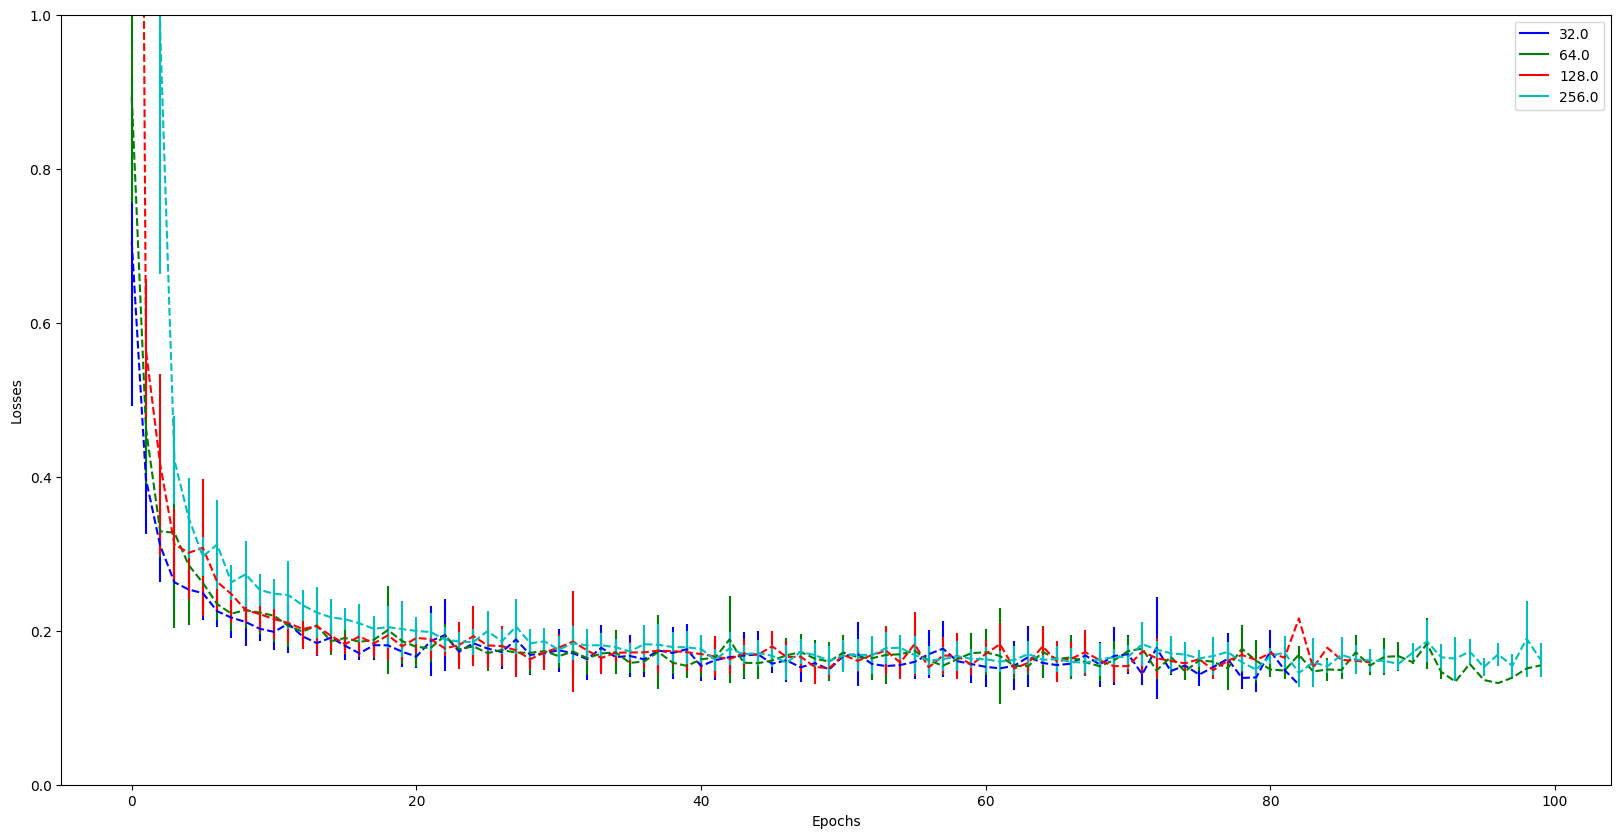

In [118]:
csvs_paths=get_csvs_ending_with("BS")
bs=[get_param(i,"batch_size") for i in csvs_paths]
n_experiments=len(bs)
idxs_sorted=np.argsort(bs)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
bs=np.sort(bs)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("batch size: " + str(bs[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    #plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(bs[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

## Review of parameters of augmentation

After manual inspection of augmented traces seems like resizing doesnt make aliases in most of the samples, but we observed that the noise levels were to high. So the first parameter to check if it helps would be the noise level.

### Noise level

## Search of resnet structure

filter_sizes: 100
Train Acc: 97.12 +- 0.56 % 
Valid Acc: 96.06 +- 0.48 % 
Test Acc: 92.13 +- 1.20 % 
Test Accuracy estimator: 92.13 +- 0.27 % . Median:92.16
filter_sizes: 128
Train Acc: 96.86 +- 0.55 % 
Valid Acc: 95.72 +- 0.44 % 
Test Acc: 92.59 +- 2.09 % 
Test Accuracy estimator: 92.59 +- 0.47 % . Median:92.78


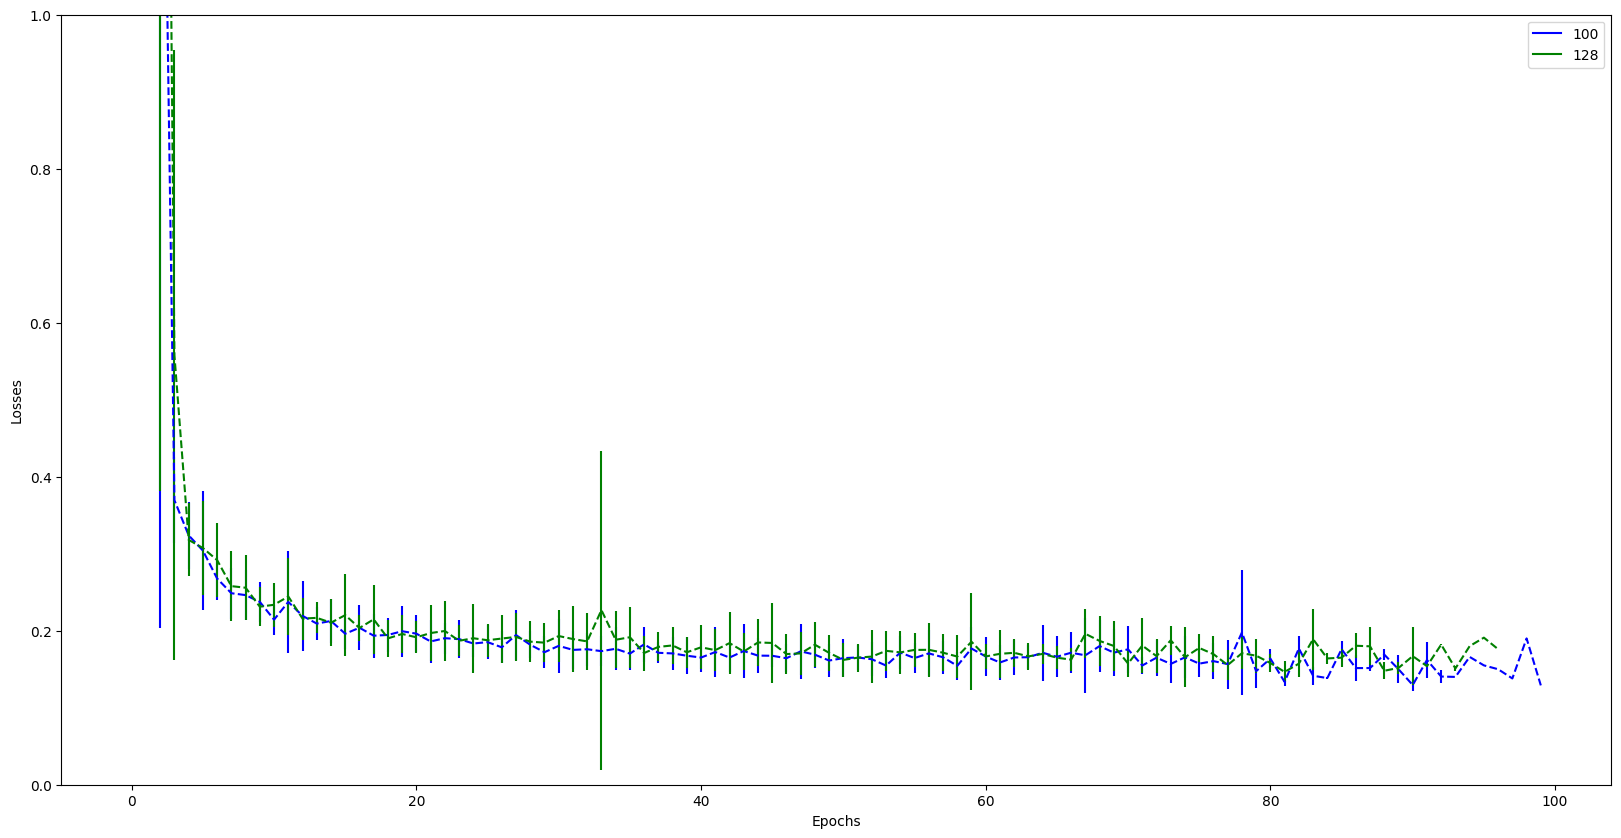

In [147]:
csvs_paths=get_csvs_ending_with("Resnet_Filter")
filter_sizes=[100, 128] ## Log didnt include the parameter easily to extract
n_experiments=len(filter_sizes)
idxs_sorted=np.argsort(filter_sizes)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
filter_sizes=np.sort(filter_sizes)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("filter_sizes: " + str(filter_sizes[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    #plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(filter_sizes[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

## Other code backup

In [145]:
csvs_paths

['../../results/ResNetTuning/Results/20231015_10-15-15_Resnet_Filter.csv',
 '../../results/ResNetTuning/Results/20231015_00-56-03_Resnet_Filter.csv']

In [4]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files


In [6]:
from DataAugmentator import DataAugmentator
from DataLoader import DataLoader
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1], 'GPU')

dl=DataLoader();
X_train,X_valid,Y_train,Y_valid,X_test,Y_test=dl.get_datasets_numpy();

In [10]:
da=DataAugmentator(opt_aug=False,noise_std=0);
out=da.all_augments(X_train[:100,:])

In [26]:
np.std(out[5,600:])

0.009132031592305462

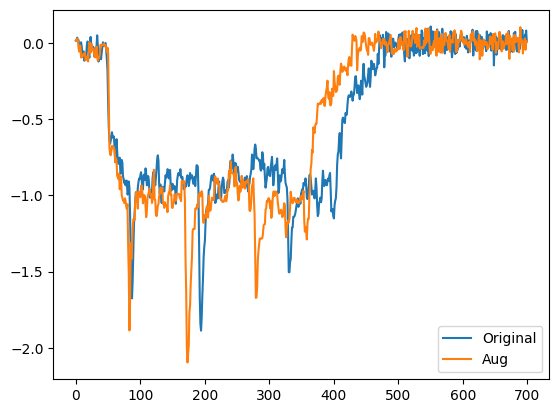

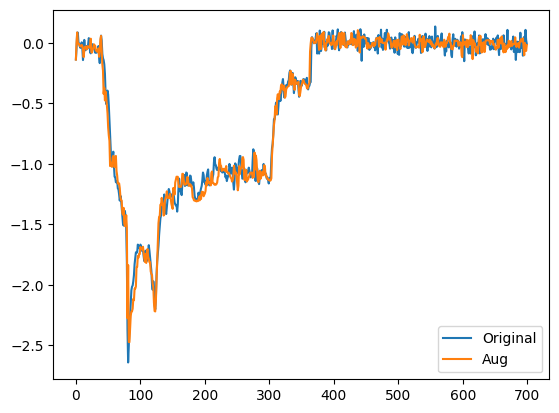

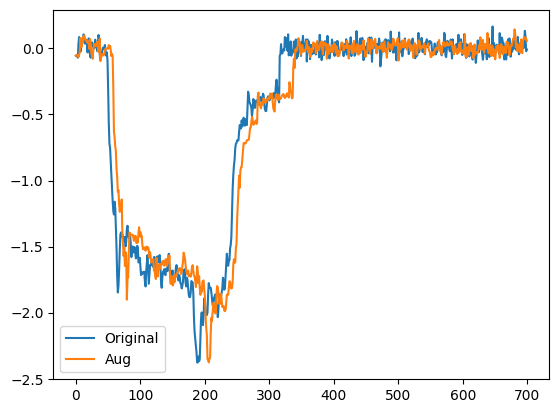

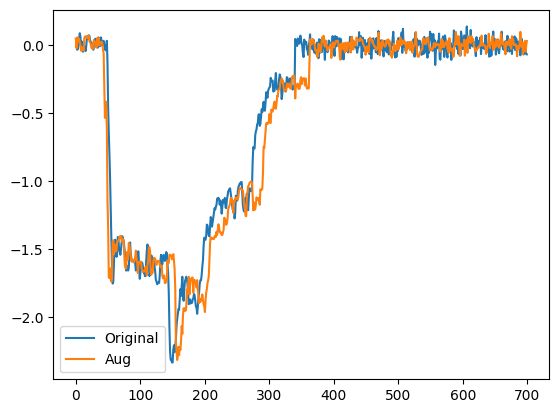

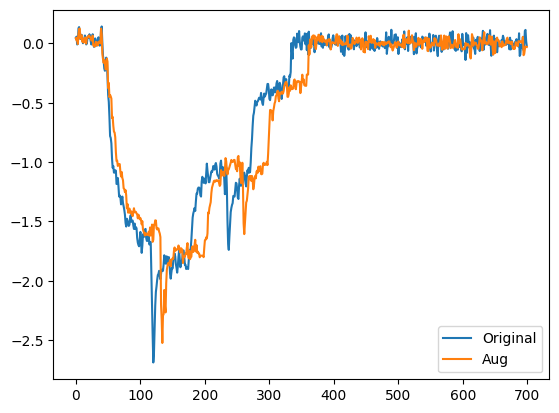

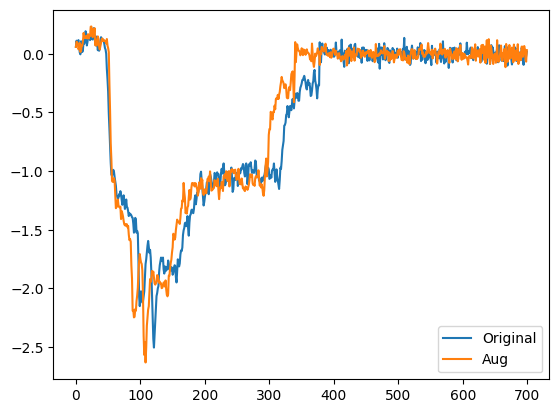

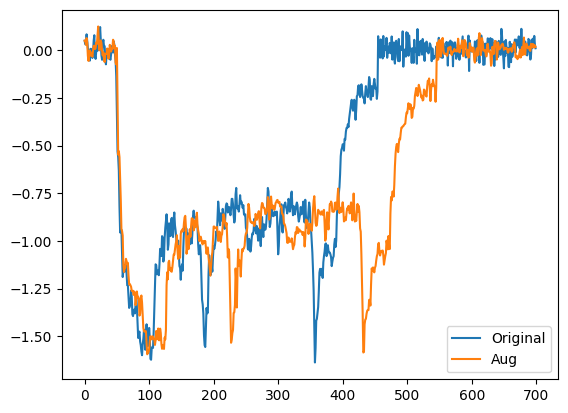

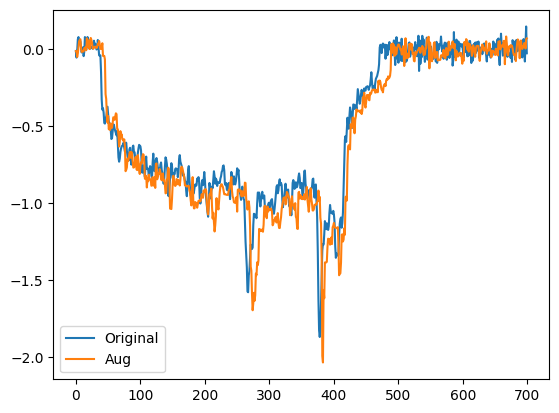

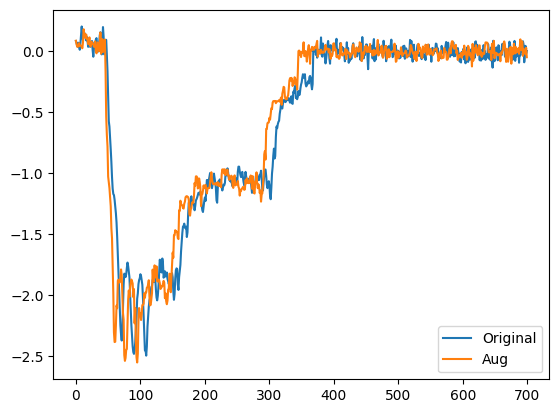

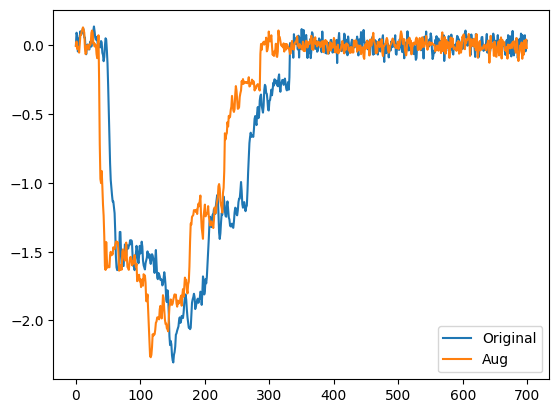

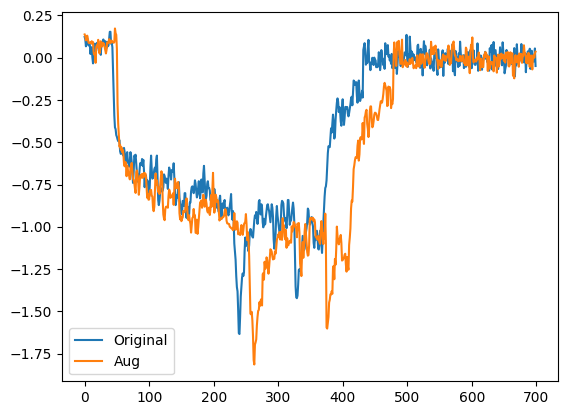

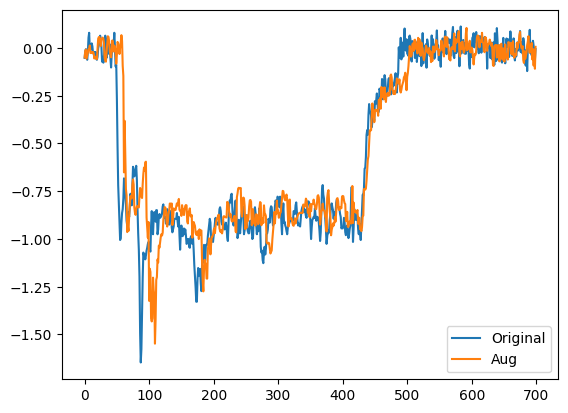

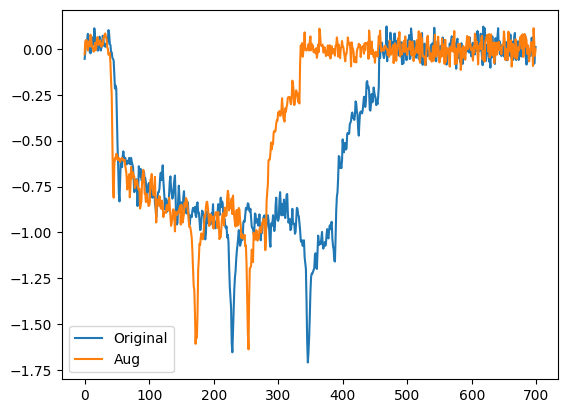

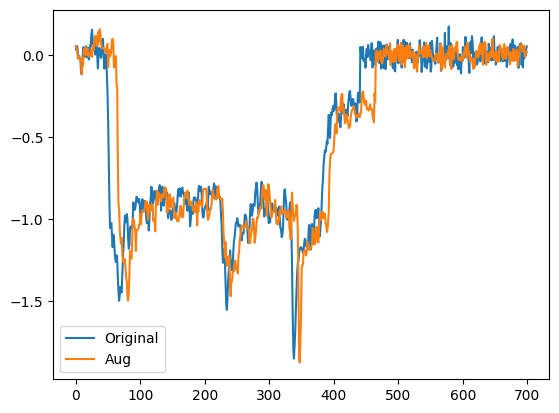

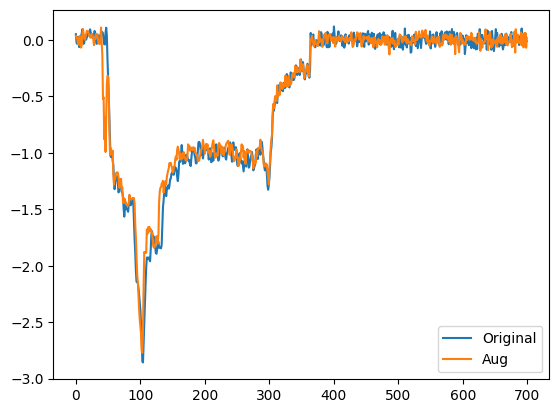

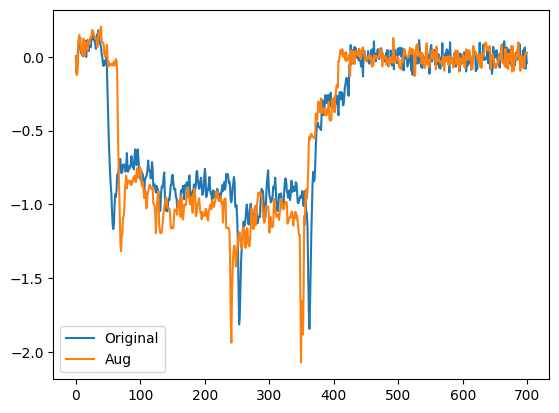

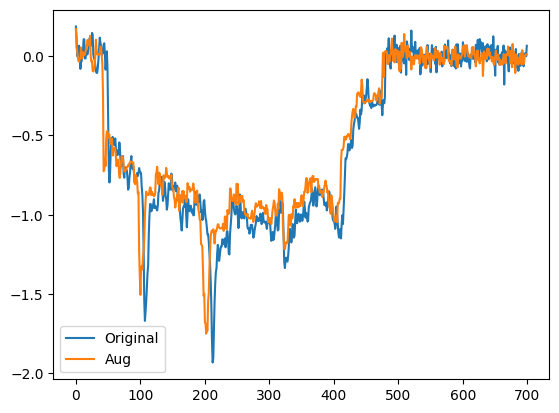

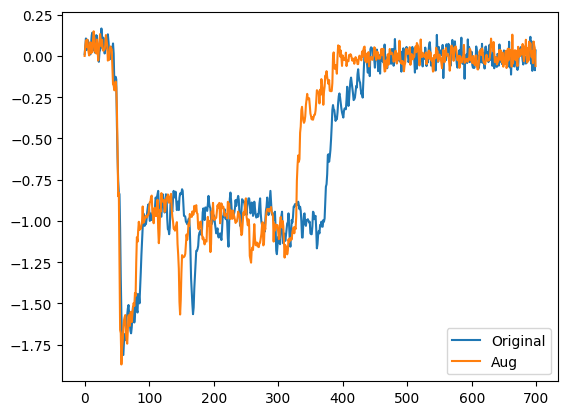

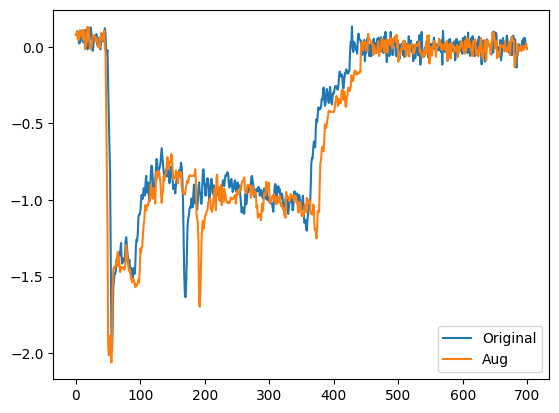

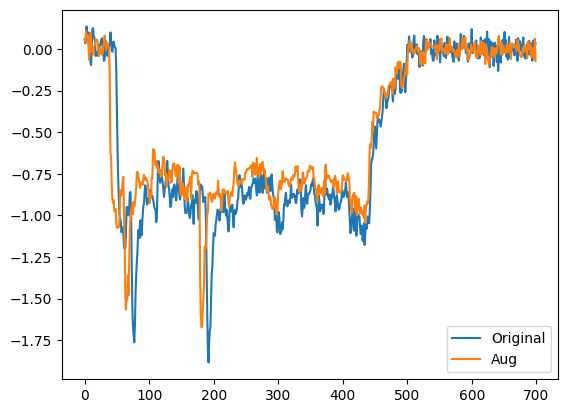

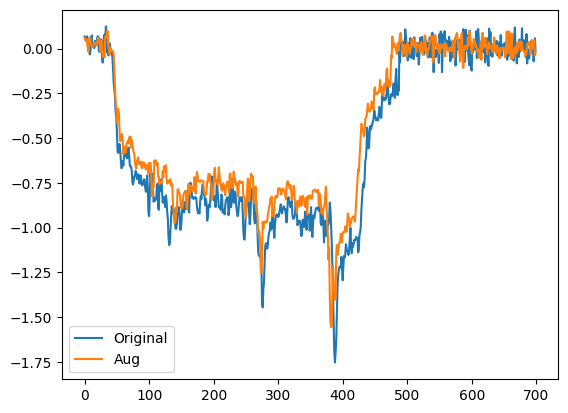

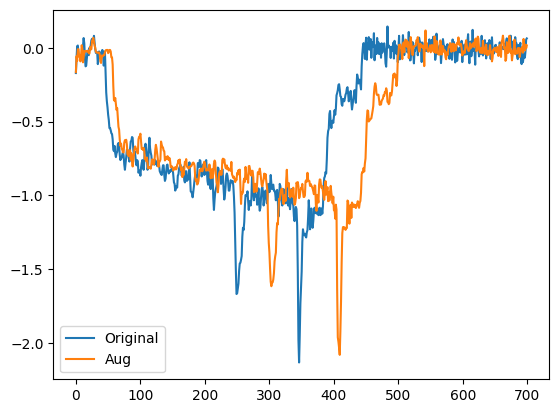

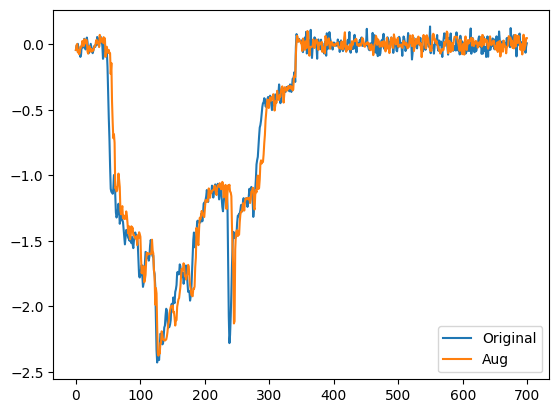

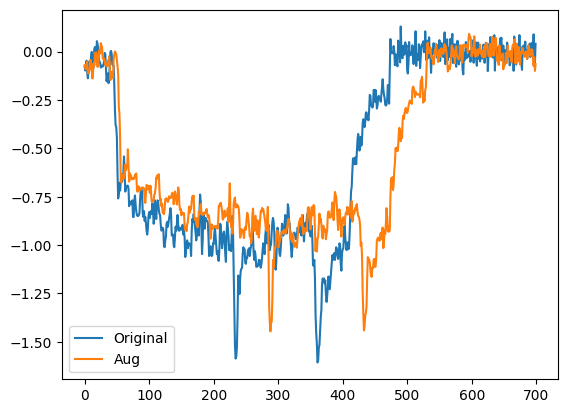

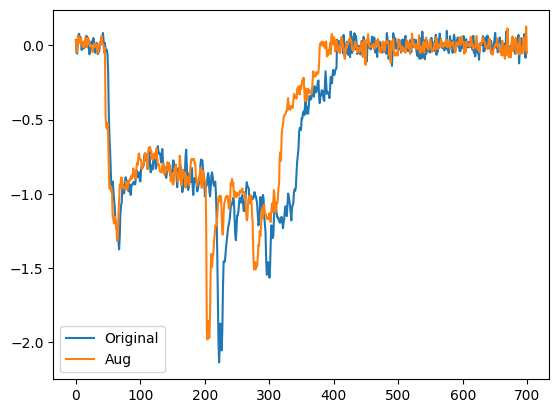

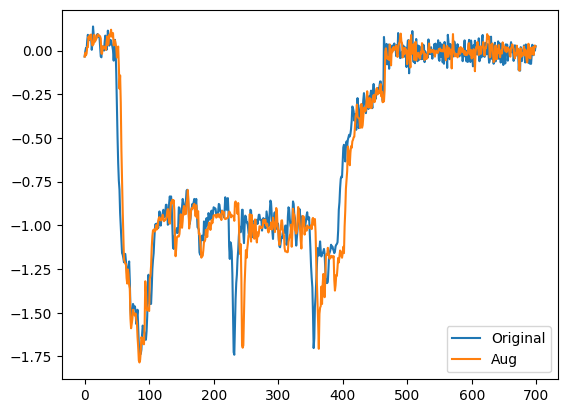

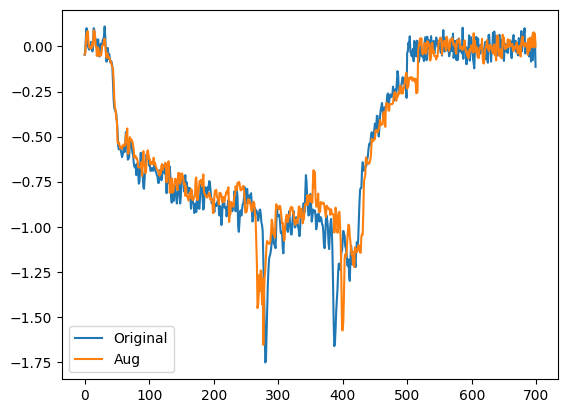

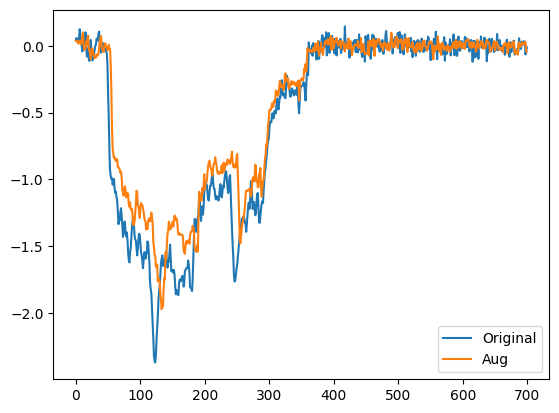

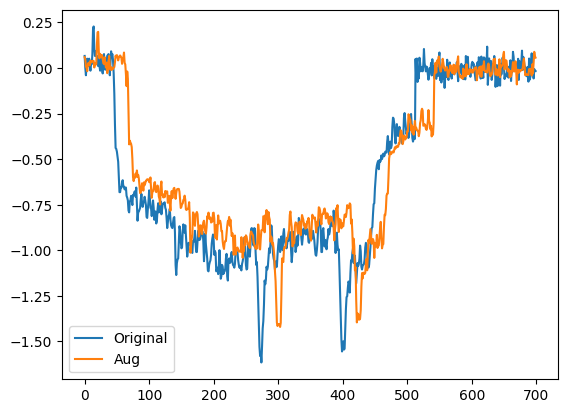

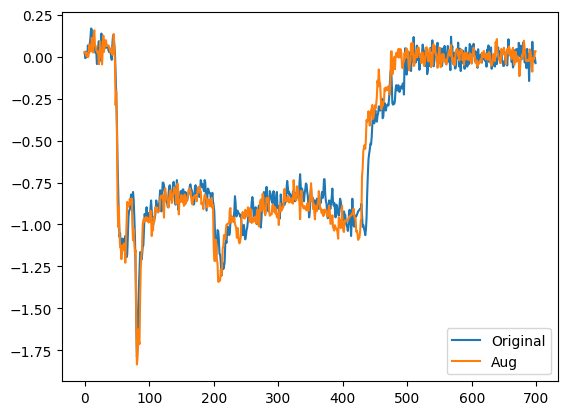

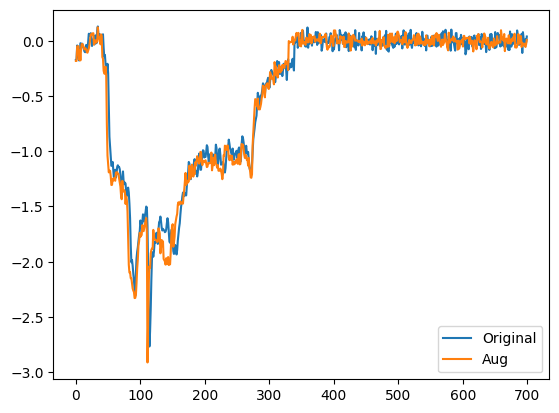

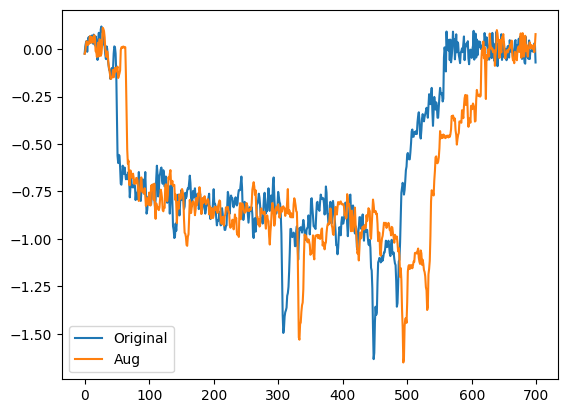

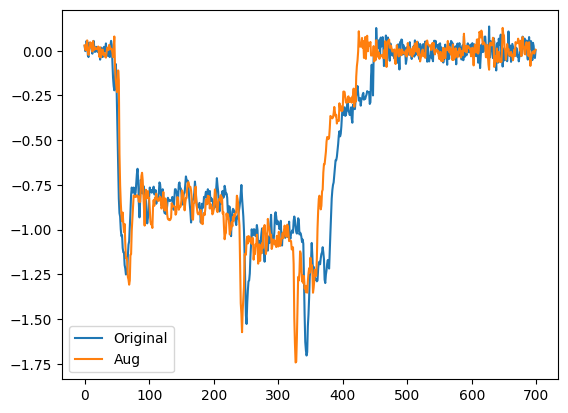

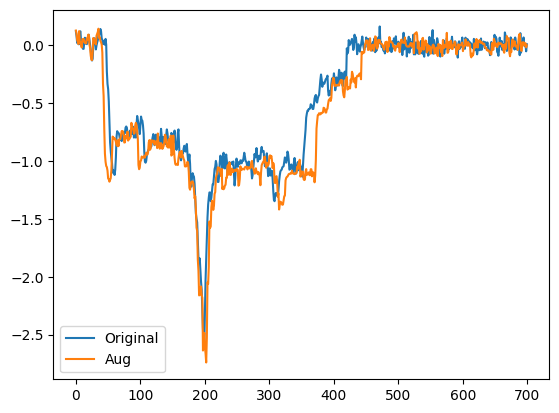

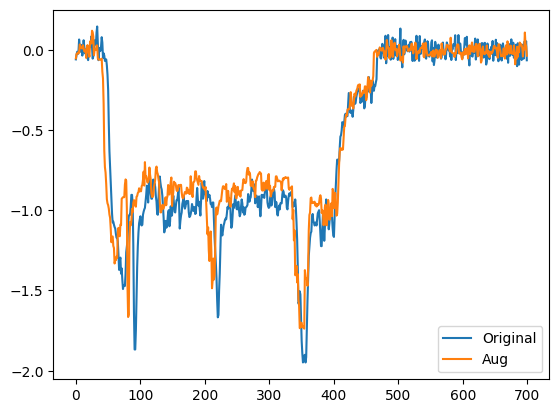

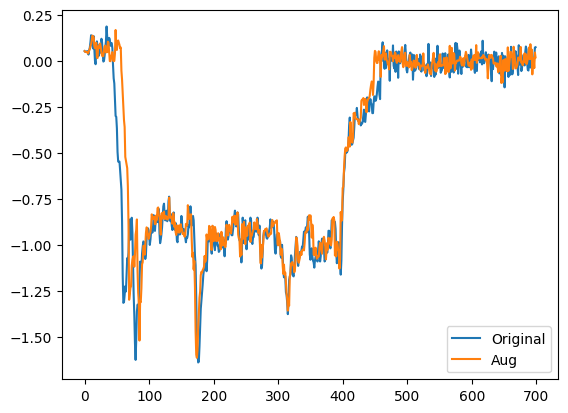

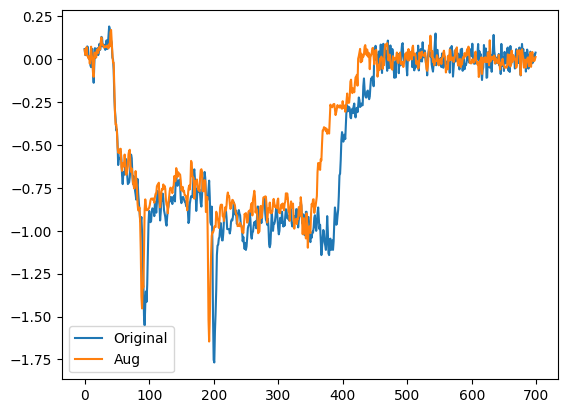

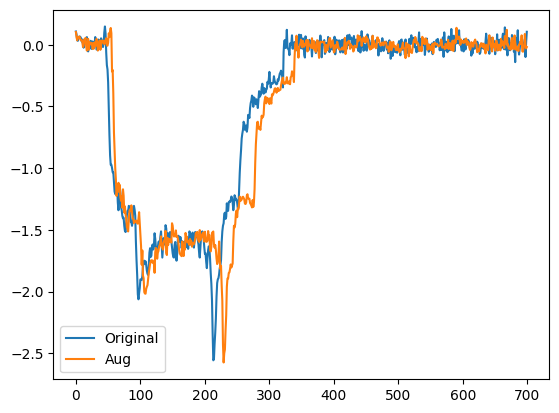

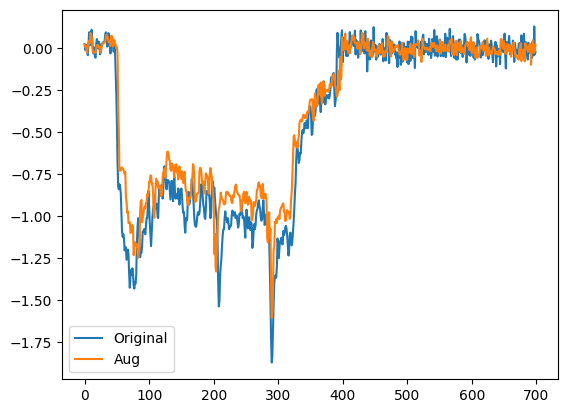

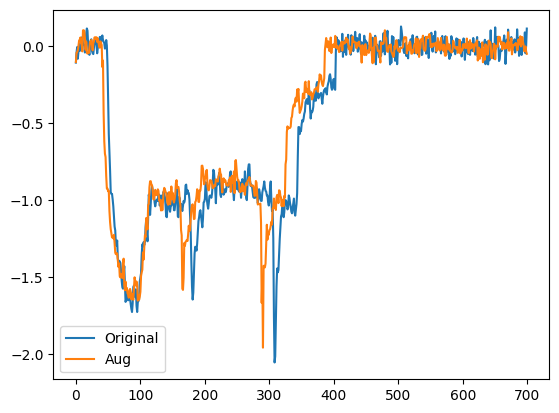

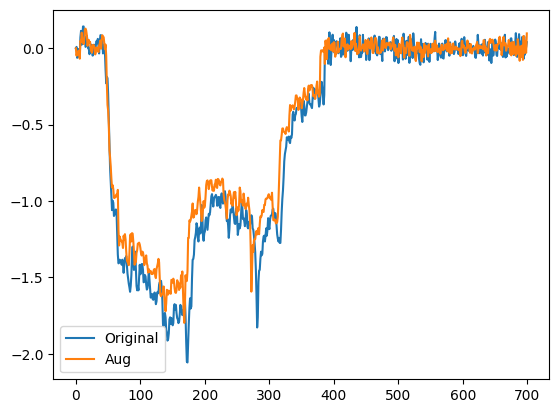

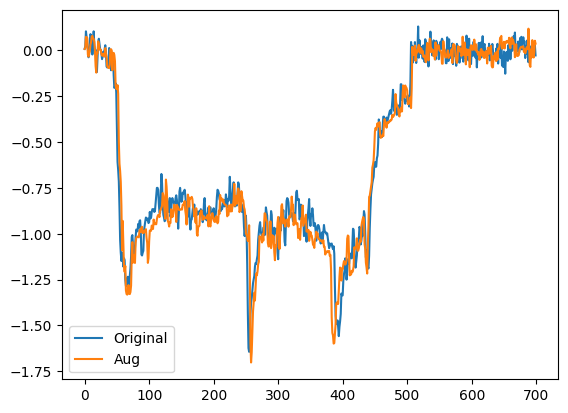

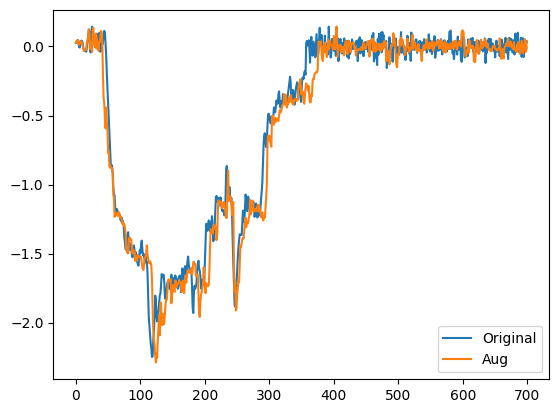

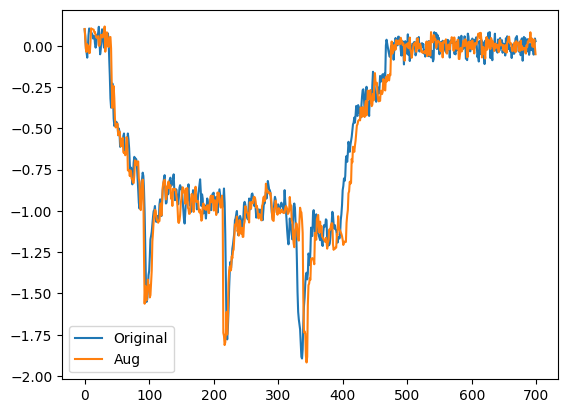

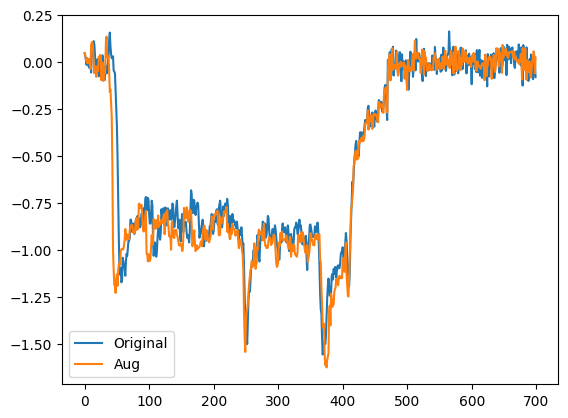

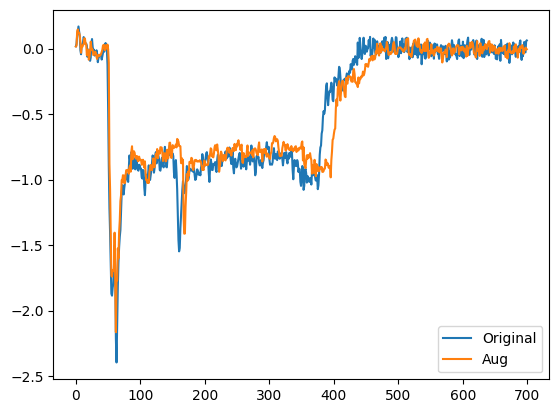

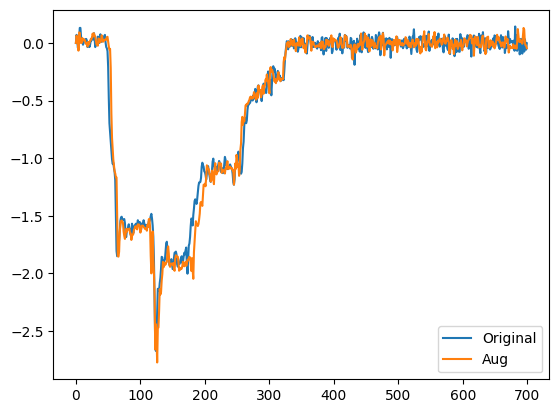

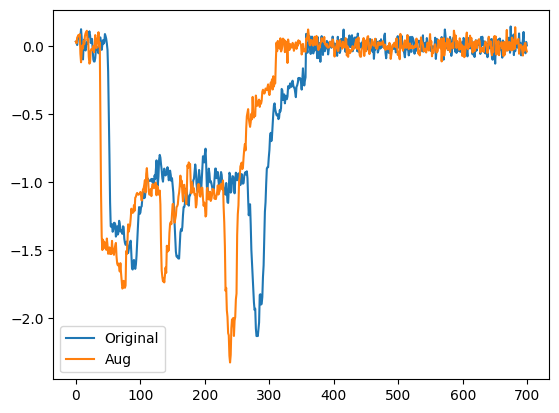

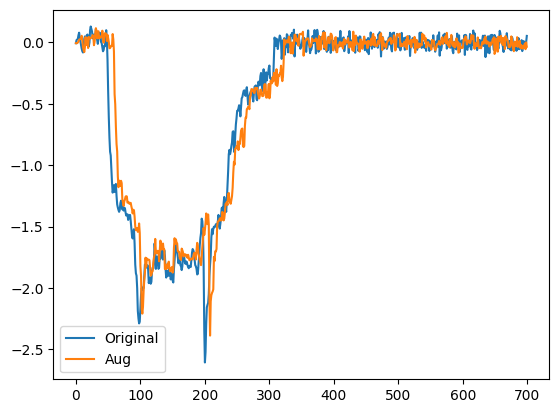

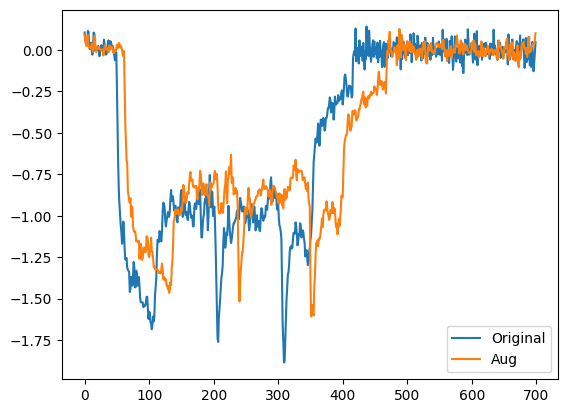

In [11]:
for i in range(50):
    plt.plot(X_train[i,:],label="Original")
    plt.plot(out[i,:],label="Aug")
    plt.legend()
    plt.show()

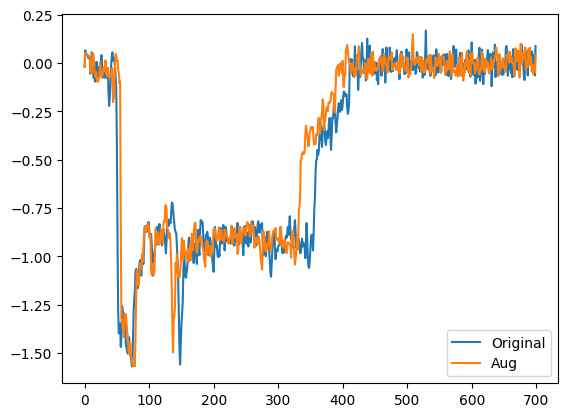

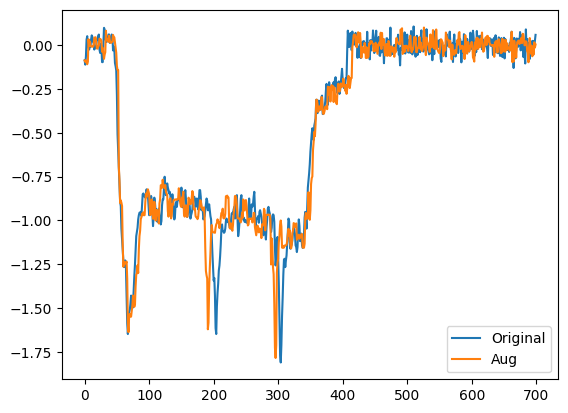

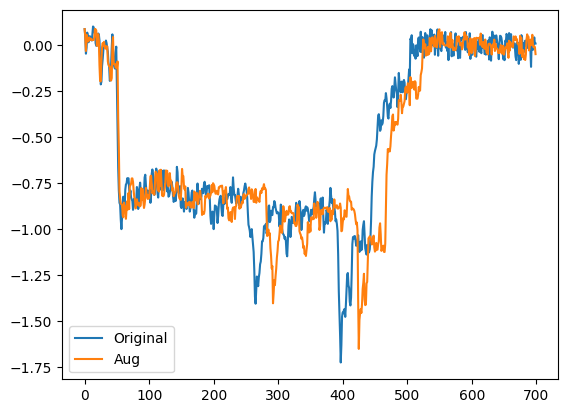

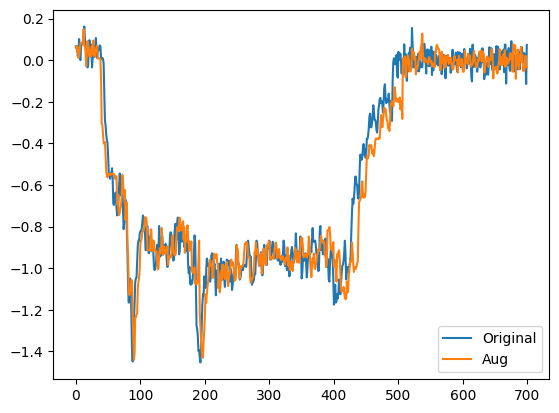

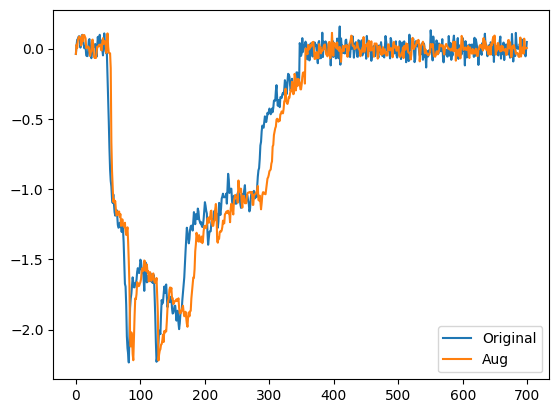

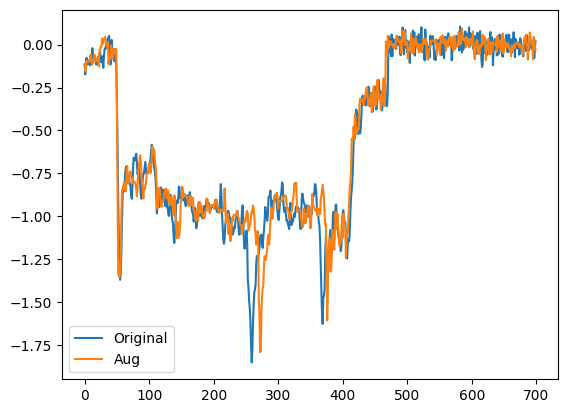

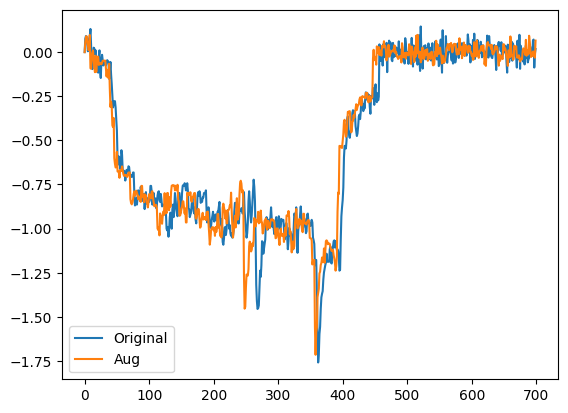

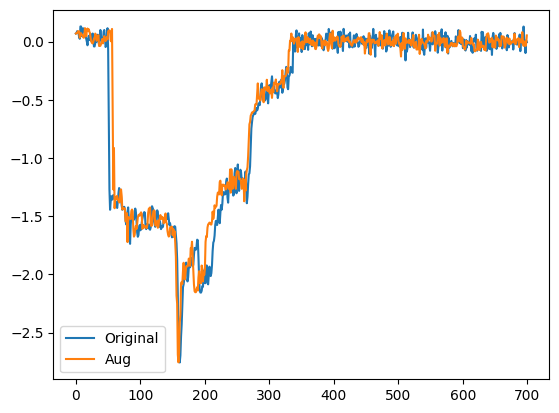

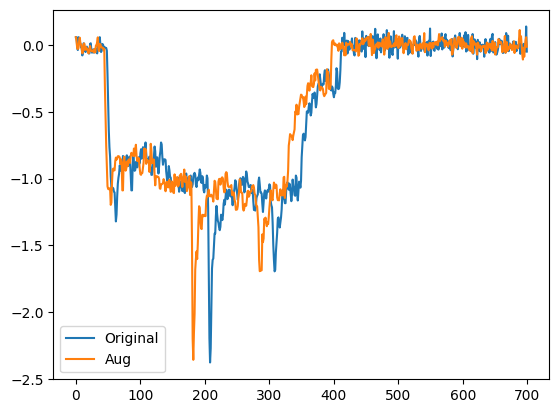

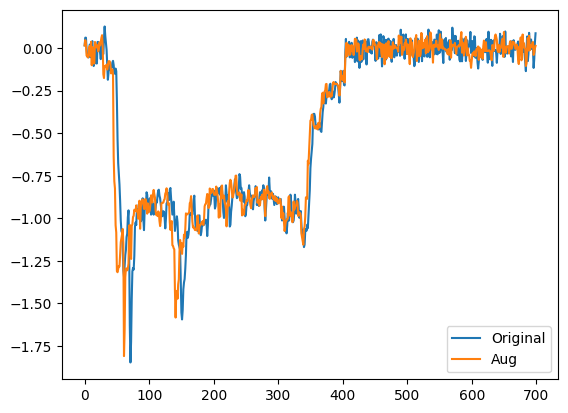

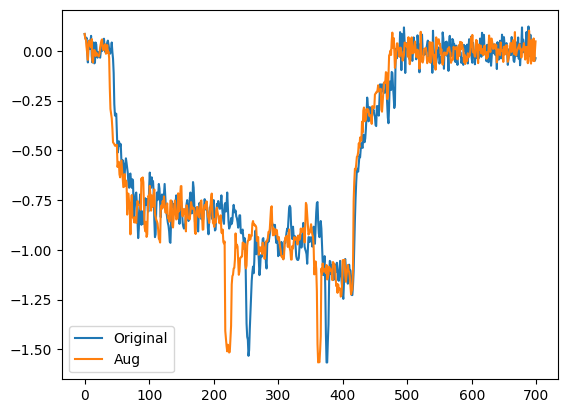

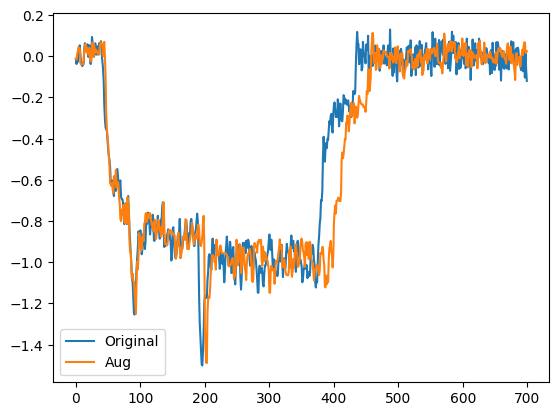

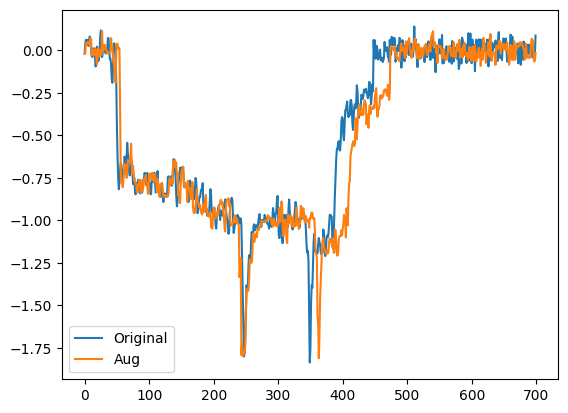

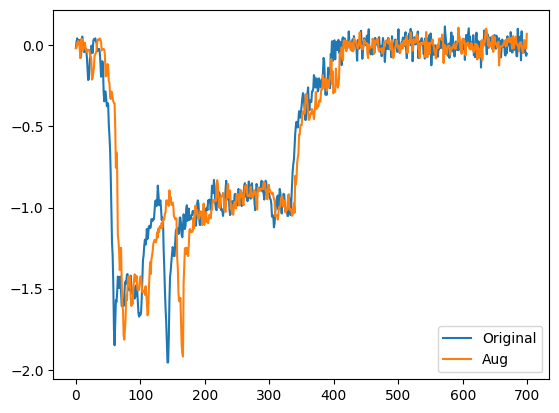

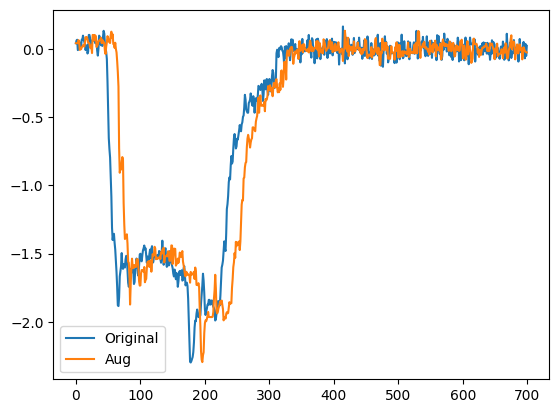

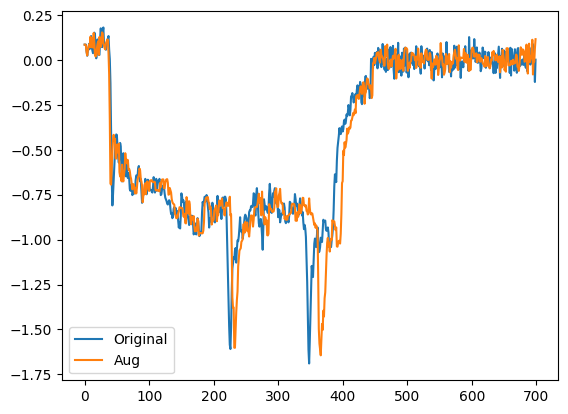

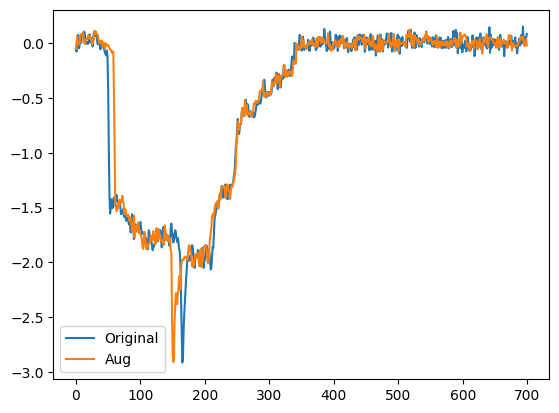

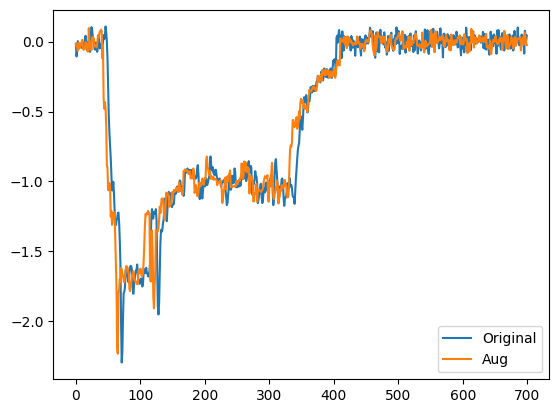

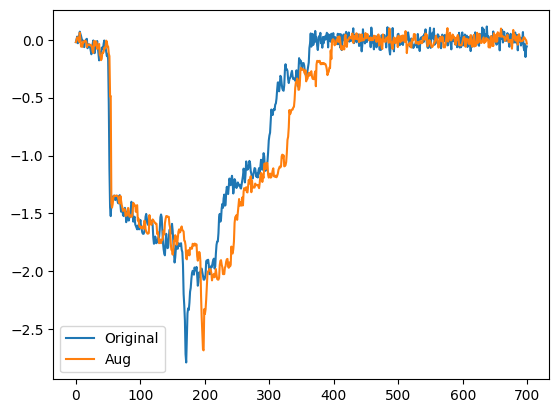

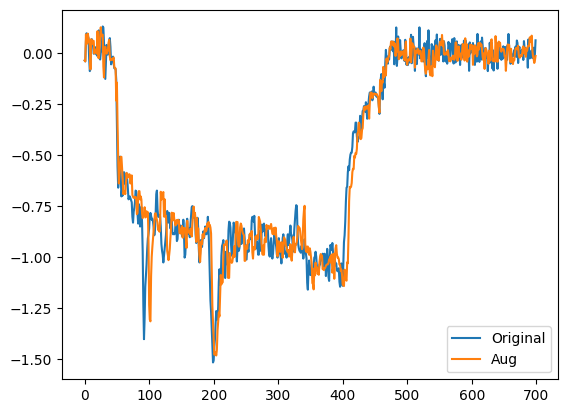

In [5]:
from DataAugmentator import test_weird_noise
test_weird_noise()